<a href="https://colab.research.google.com/github/Kuliah-Machine-Learning/2021-Batik-Kel-1/blob/main/Batik_Classifier_VGG16_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Kuliah-Machine-Learning/2021-Batik-Kel-1

Cloning into '2021-Batik-Kel-1'...
remote: Enumerating objects: 2910, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 2910 (delta 3), reused 42 (delta 1), pack-reused 2855
Receiving objects: 100% (2910/2910), 45.83 MiB | 30.42 MiB/s, done.
Resolving deltas: 100% (23/23), done.


In [ ]:
%cd 2021-Batik-Kel-1

/content/2021-Batik-Kel-1/2021-Batik-Kel-1/2021-Batik-Kel-1


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import numpy as np 
import math, os, sys
import itertools

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize

import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

In [ ]:
#Perintah di bawah ini untuk melihat list bagian dari file yang sudah diunduh dari Github
!ls Data/
!ls Data/Train/Banji
!ls Data/Train/Kawung
!ls Data/Train/Parang
!ls Data/Train/Tumpal

Train  Validasi
B16.jpg  B77.jpg
B17.jpg  B78.jpg
B19.jpg  B81.jpg
B21.jpg  B84.jpg
B24.jpg  B85.jpg
B27.jpg  B86.jpg
B28.jpg  B88.jpg
B31.jpg  B90.jpg
B32.jpg  BV16_jpg.rf.094df28bc22104ed046bb078af58c094.jpg
B33.jpg  BV16_jpg.rf.0fa56c36b428d8c6b5a543490599395a.jpg
B35.jpg  BV16_jpg.rf.2f075fbd60299676be4bd94dc4bb9096.jpg
B36.jpg  BV16_jpg.rf.3fe962cf779b384b11b7d1838d07fcc6.jpg
B38.jpg  BV16_jpg.rf.6233c346585e155100b5b9b9ca5177c8.jpg
B40.jpg  BV16_jpg.rf.794b7e472506e49be7e66499d70dd798.jpg
B41.jpg  BV17_jpg.rf.24ee2700728879a6189a9c36663a7bb6.jpg
B47.jpg  BV17_jpg.rf.3ef06c9d13663a152d46f917ae0fc4d6.jpg
B51.jpg  BV17_jpg.rf.806f33ae56166bc0018bcba05a57a247.jpg
B55.jpg  BV17_jpg.rf.e43899267d1fcb95dddb72b72d979577.jpg
B56.jpg  BV18_jpg.rf.070fe8ef4d7f26df3e9ac7de8d004de3.jpg
B58.jpg  BV18_jpg.rf.16eb44d76fcf94244ed9a144707002a8.jpg
B59.jpg  BV18_jpg.rf.1b9aa226654a07df4a00f05c86e1602f.jpg
B60.jpg  BV18_jpg.rf.2d671b087e6cd7cf2bec234cb00152ae.jpg
B64.jpg  BV18_jpg.rf.792a410f9cf94e7

In [ ]:
#Memuat semua gambar ke memori untuk pertama kali

#Memuat dataset pelatihan
IMAGE_SIZE = 200
BATCH_SIZE = 32
base_dir = os.path.join('Data/Train')

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.3)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

#Memuat dataset pengujian
X_test = []
y_test = []
labels = ['Banji', 'Kawung', 'Parang', 'Tumpal']

for i,label in enumerate(labels):
    folder = os.path.join("Data/Validasi",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)
        
        image = imread(image_path)/255.
        image = resize(image,(200,200))
        X_test.append(image)
        category = os.path.split(folder)[-1]
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

#Menampilkan bentuk dari masing-masing dataset
for image_batch, label_batch in train_generator:
  break
print("Bentuk array dari dataset train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_generator:
  break
print("Bentuk array dari dataset validation (validasi) adalah:", image_batch.shape,label_batch.shape)
print("Bentuk array dari dataset test (pengujian) adalah:", X_test.shape,y_test.shape)

Found 301 images belonging to 4 classes.
Found 128 images belonging to 4 classes.
Bentuk array dari dataset train (pelatihan) adalah: (32, 200, 200, 3) (32, 4)
Bentuk array dari dataset validation (validasi) adalah: (32, 200, 200, 3) (32, 4)
Bentuk array dari dataset test (pengujian) adalah: (82, 200, 200, 3) (82,)


In [ ]:
print (train_generator.class_indices)

labels_txt = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels_txt)

{'Banji': 0, 'Kawung': 1, 'Parang': 2, 'Tumpal': 3}


In [ ]:
!cat labels.txt

Banji
Kawung
Parang
Tumpal

In [ ]:
IMG_SHAPE = (200, 200, 3)
# Membuat model dasar (base model) dari pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

In [ ]:
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [ ]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

In [ ]:
y_test2 = to_categorical(y_test)
X_test3, y_test3 = (X_test, y_test2)

In [ ]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 18432)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               9437696   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 24,154,436
Trainable params: 9,439,748
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
#from keras.callbacks import EarlyStopping, ModelCheckpoint

#Menyimpan file model bobot yang terbaik selama pelatihan (dalam format keras ".h5")
#ckpt = ModelCheckpoint("Klasifikasi Beras Tumpukan.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
history = model.fit(train_generator, 
                    epochs=25, 
                    validation_data=val_generator)
#history = model.fit(x = X_train3, y = y_train3, batch_size=120, epochs= 100,validation_data=(X_valid3,y_valid3),callbacks = [ckpt])

Epoch 1/25
10/10 [==============================] - 153s 16s/step - loss: 2.6233 - acc: 0.5083 - val_loss: 0.9653 - val_acc: 0.6875
Epoch 2/25
10/10 [==============================] - 150s 15s/step - loss: 0.3266 - acc: 0.9003 - val_loss: 0.5710 - val_acc: 0.7891
Epoch 3/25
10/10 [==============================] - 149s 15s/step - loss: 0.1038 - acc: 0.9734 - val_loss: 1.0607 - val_acc: 0.7422
Epoch 4/25
10/10 [==============================] - 149s 15s/step - loss: 0.1259 - acc: 0.9701 - val_loss: 0.8536 - val_acc: 0.7812
Epoch 5/25
10/10 [==============================] - 149s 15s/step - loss: 0.1273 - acc: 0.9435 - val_loss: 0.7648 - val_acc: 0.8438
Epoch 6/25
10/10 [==============================] - 149s 15s/step - loss: 0.0372 - acc: 0.9934 - val_loss: 0.7709 - val_acc: 0.8125
Epoch 7/25
10/10 [==============================] - 150s 15s/step - loss: 0.0171 - acc: 0.9967 - val_loss: 0.8397 - val_acc: 0.8047
Epoch 8/25
10/10 [==============================] - 149s 15s/step - loss: 0.

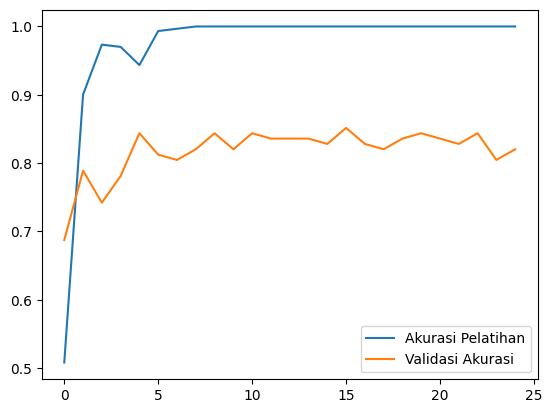

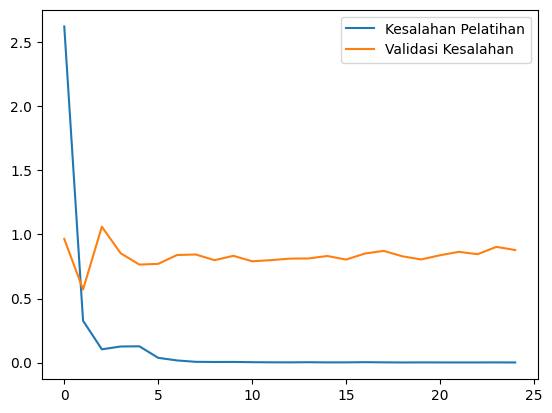

In [ ]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kesalahan")
plt.legend()
plt.show()

In [ ]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4


In [ ]:
print(train_generator)

In [ ]:
#Prediksi Label Validasi dengan Pelatihan
n = 10
input_image = image_batch[n][np.newaxis,...]
print("Labelnya adalah: ", label_batch[n])

predictions = model.predict(input_image)
print("Prediksinya adalah",predictions[0])

Labelnya adalah:  [0. 1. 0. 0.]
Prediksinya adalah [4.4412220e-05 9.9965930e-01 2.9602967e-04 2.8820261e-07]


In [ ]:
#Memeriksa matriks model
print(model.metrics_names)
#Evaluasi data training
print(model.evaluate(train_generator))
#Evaluasi validasi data
print(model.evaluate(val_generator))
#Evaluasi data test
print(model.evaluate(x= X_test3, y = y_test3)) 

['loss', 'acc']
10/10 [==============================] - 105s 10s/step - loss: 5.8649e-04 - acc: 1.0000
[0.0005864897975698113, 1.0]
4/4 [==============================] - 45s 11s/step - loss: 0.8787 - acc: 0.8203
[0.8786946535110474, 0.8203125]
3/3 [==============================] - 29s 9s/step - loss: 1.4432 - acc: 0.7805
[1.4432061910629272, 0.7804877758026123]


In [ ]:
#Menampilkan matriks yang benar dan matriks hasil prediksi

#Label yang benar
y_true = np.argmax(y_test2,axis=1)

#Label prediksi
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3]
[1 1 0 2 0 1 1 3 2 0 2 3 3 3 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2
 1 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 3 2 3 3 3 3 3 3 3 0 3 3 3 3 2 3 3
 2 3 3 3 3 3 3 3]


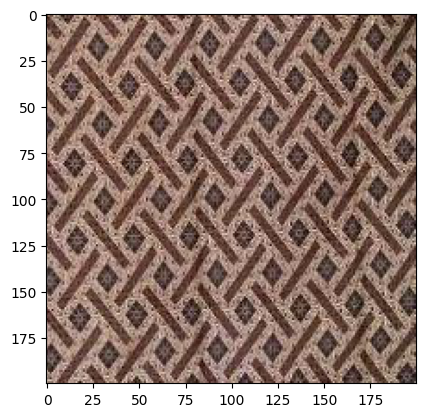

Label yang benar adalah: 0 : Banji
Nilai yang diprediksi adalah: [4.629879e-02 9.479673e-02 8.581184e-01 7.860839e-04]
Label yang diprediksi adalah: 2 : Parang
Prediksi salah


In [ ]:
n = 10 #Jangan melampaui (nilai dari gambar test - 1)

plt.imshow(X_test[n])
plt.show()

true_label = np.argmax(y_test2,axis=1)[n]
print("Label yang benar adalah:",true_label,":",labels[true_label])
prediction = model.predict(X_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah:",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
    print("Prediksi benar")
else:
    print("Prediksi salah")

Normalized confusion matrix
[[0.27 0.27 0.2  0.27]
 [0.   1.   0.   0.  ]
 [0.   0.13 0.87 0.  ]
 [0.04 0.   0.12 0.84]]


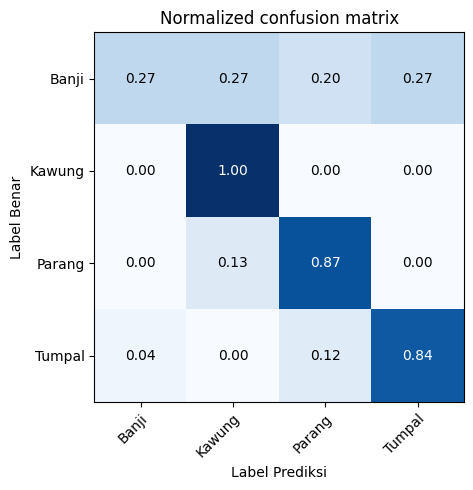

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Label Benar',
           xlabel='Label Prediksi')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')